# CNNs for Real Images

In [35]:
import cv2
import glob
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from glob import glob
from PIL import Image
from torch import optim
from torchvision import transforms, models, datasets
from torch.utils.data import Dataset, DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [36]:
#!pip install -q kaggle
#from google.colab import files
#files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"heitorpavaninolla","key":"5d8834898c8395461e589ea3163e03d0"}'}

In [37]:
#!mkdir -p ~/.kaggle
#!cp kaggle.json ~/.kaggle/
#!ls ~/.kaggle
#!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [38]:
#!kaggle datasets download -d tongpython/cat-and-dog
#!unzip cat-and-dog.zip

Dataset URL: https://www.kaggle.com/datasets/tongpython/cat-and-dog
License(s): CC0-1.0
cat-and-dog.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  cat-and-dog.zip
replace test_set/test_set/cats/_DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [39]:
train_data_dir = '/content/training_set/training_set'
test_data_dir = '/content/test_set/test_set'

In [40]:
from torch.utils.data import DataLoader, Dataset
from random import shuffle, seed
seed(10)

class cats_dogs(Dataset):
  def __init__(self, folder):
    cats = glob(folder+'/cats/*.jpg')
    dogs = glob(folder+'/dogs/*.jpg')

    self.fpaths = cats + dogs
    shuffle(self.fpaths)

    self.targets = [fpath.split('/')[-1].startswith('dog') \
                      for fpath in self.fpaths]

  def __len__(self):
    return len(self.fpaths)

  def __getitem__(self, index):
    f = self.fpaths[index]
    target = self.targets[index]
    im = (cv2.imread(f)[:,:,::-1])
    im = cv2.resize(im, (224, 224))

    return torch.tensor(im/255).permute(2, 0, 1).to(device).float(), \
           torch.tensor([target]).float().to(device)

tensor([1.], device='cuda:0')


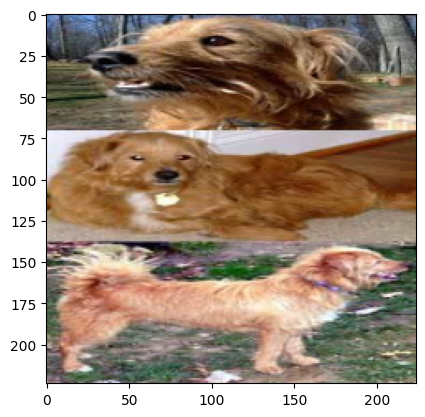

In [41]:
data = cats_dogs(train_data_dir)
im, label = data[200]
plt.imshow(im.permute(1,2,0).cpu())
print(label)

In [42]:
def conv_layer(ni, no, kernel_size, stride=1):
  return nn.Sequential(
      nn.Conv2d(ni, no, kernel_size, stride),
      nn.ReLU(),
      nn.BatchNorm2d(no),
      nn.MaxPool2d(2)
  )

In [43]:
def get_model():
  model = nn.Sequential(
      conv_layer(3, 64, 3),
      conv_layer(64, 512, 3),
      conv_layer(512, 512, 3),
      conv_layer(512, 512, 3),
      conv_layer(512, 512, 3),
      conv_layer(512, 512, 3),
      nn.Flatten(),
      nn.Linear(512, 1),
      nn.Sigmoid(),
  ).to(device)

  loss_fn = nn.BCELoss()
  optimizer = optim.Adam(model.parameters(), lr=1e-3)

  return model, loss_fn, optimizer

In [44]:
!pip install torch_summary
from torchsummary import summary

model, loss_fn, optimizer = get_model()
summary(model, torch.zeros(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 111, 111]        --
|    └─Conv2d: 2-1                       [-1, 64, 222, 222]        1,792
|    └─ReLU: 2-2                         [-1, 64, 222, 222]        --
|    └─BatchNorm2d: 2-3                  [-1, 64, 222, 222]        128
|    └─MaxPool2d: 2-4                    [-1, 64, 111, 111]        --
├─Sequential: 1-2                        [-1, 512, 54, 54]         --
|    └─Conv2d: 2-5                       [-1, 512, 109, 109]       295,424
|    └─ReLU: 2-6                         [-1, 512, 109, 109]       --
|    └─BatchNorm2d: 2-7                  [-1, 512, 109, 109]       1,024
|    └─MaxPool2d: 2-8                    [-1, 512, 54, 54]         --
├─Sequential: 1-3                        [-1, 512, 26, 26]         --
|    └─Conv2d: 2-9                       [-1, 512, 52, 52]         2,359,808
|    └─ReLU: 2-10                        [-1, 512, 52, 52]        

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 111, 111]        --
|    └─Conv2d: 2-1                       [-1, 64, 222, 222]        1,792
|    └─ReLU: 2-2                         [-1, 64, 222, 222]        --
|    └─BatchNorm2d: 2-3                  [-1, 64, 222, 222]        128
|    └─MaxPool2d: 2-4                    [-1, 64, 111, 111]        --
├─Sequential: 1-2                        [-1, 512, 54, 54]         --
|    └─Conv2d: 2-5                       [-1, 512, 109, 109]       295,424
|    └─ReLU: 2-6                         [-1, 512, 109, 109]       --
|    └─BatchNorm2d: 2-7                  [-1, 512, 109, 109]       1,024
|    └─MaxPool2d: 2-8                    [-1, 512, 54, 54]         --
├─Sequential: 1-3                        [-1, 512, 26, 26]         --
|    └─Conv2d: 2-9                       [-1, 512, 52, 52]         2,359,808
|    └─ReLU: 2-10                        [-1, 512, 52, 52]        

In [45]:
def get_data():
  train = cats_dogs(train_data_dir)
  trn_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last=True)

  val = cats_dogs(test_data_dir)
  val_dl = DataLoader(val, batch_size=32, shuffle=True, drop_last=True)

  return trn_dl, val_dl

In [46]:
def train_batch(x, y, model, opt, loss_fn):
  model.train()

  pred = model(x)
  batch_loss = loss_fn(pred, y)
  batch_loss.backward()
  opt.step()
  opt.zero_grad()

  return batch_loss.item()

In [47]:
@torch.no_grad()
def accuracy(x, y, model):
  model.eval()

  pred = model(x)
  is_correct = (pred > 0.5) == y

  return is_correct.cpu().numpy().tolist()

@torch.no_grad()
def val_loss(x, y, model):
  model.eval()

  pred = model(x)
  val_loss = loss_fn(pred, y)

  return val_loss.item()

In [48]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(5):
  print(epoch)
  train_epoch_losses, train_epoch_accuracies = [], []
  val_epoch_accuracies = []

  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    batch_loss = train_batch(x, y, model, optimizer, loss_fn)
    train_epoch_losses.append(batch_loss)
  train_epoch_loss = np.array(train_epoch_losses).mean()

  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    is_correct = accuracy(x, y, model)
    train_epoch_accuracies.extend(is_correct)
  train_epoch_accuracy = np.mean(train_epoch_accuracies)

  for ix, batch in enumerate(iter(val_dl)):
    x, y = batch
    val_is_correct = accuracy(x, y, model)
    val_epoch_accuracies.extend(val_is_correct)
  val_epoch_accuracy = np.mean(val_epoch_accuracies)

  train_losses.append(train_epoch_loss)
  train_accuracies.append(train_epoch_accuracy)
  val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4


/tmp/ipython-input-3256823898.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


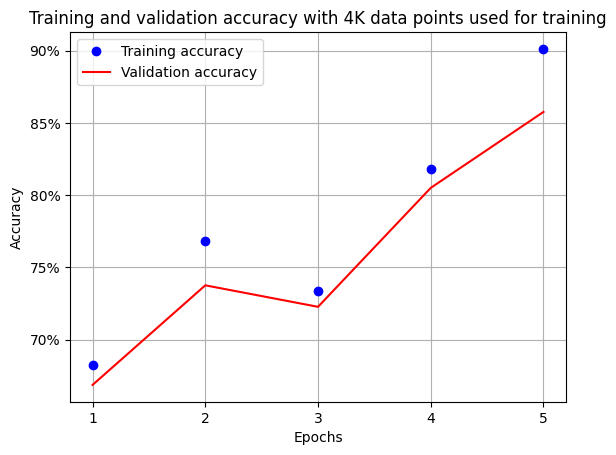

In [49]:
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline

epochs = np.arange(5)+1

plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with 4K data points used for training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()